# Bayesian inference: MCMC

## Table of Content:

- I-II-III Basic concepts of Bayesian inference: See [Bayes_basics.ipynb](Bayes_basics.ipynb)
- IV Simple Bayesian Modeling: See [Bayes_simple_modeling.ipynb](Bayes_simple_modeling.ipynb)
- V Bayesian modeling with [Monte Carlo Markov Chains (MCMC)](#V.-Bayesian-Modeling-with-MCMC)
    * V.1 [The Curse of dimensionality](#V.1-The-Curse-of-dimensionality)
    * V.2 [Circumventing the curse with sampling](#V.2-Circumventing-the-Curse-with-Sampling)
- X [References](#XX-References:)

## V. Bayesian Modeling with MCMC

In the previous section we explored a Bayesian solution to a straight line fit.
The result made use of the evaluation of a posterior across a grid of parameters: a strategy that *will not* scale to higher-dimensional models.

## V.1 The Curse of dimensionality

The reason it will not scale is one of the effects of the ubiquitous "Curse of Dimensionality". To understand this, consider how many evaluations we need for an $N$-dimensional grid with 100 samples per dimension

In one dimension, we have $100$ points.

In two dimensions we have $100^2 = 10,000$ evaluations.

In three dimensions, we have $100^3 = 1,000,000$ evaluations.

In $N$ dimensions, we have $100^N$ evaluations, and as $N$ grows this quickly becomes untenable! For example, if we have only six model parameters, this "dense grid" approach will require evaluating the posterior at one trillion grid points, the results of which would require several terabytes of memory just to store!

Evidently the dense grid strategy will not work for any but the simplest Bayesian models.

## V.2 Circumventing the Curse with Sampling

An idea that revolutionized Bayesian modeling (and made possible the wide variety of Bayesian approaches used in practice today) is *Markov Chain Monte Carlo* (MCMC), an approach that allows one to efficiently draw (pseudo)random samples from a posterior distribution even in relatively high dimensions.

*Caveat*: The remaining of this notebook provides only a brief and practical introduction to MCMC. The relevance of this method in research deserves more in-depth understanding than this introduction and example of implementation. The reader is encouraged to consult the material given in the [references](#XX-References:) to acquire a more solid understanding of MCMC, and learn about the various tastes of MCMC that have been developed to achieve an efficient sampling of complex multi-dimensional parameter space. 

### V.2.1 The Metropolis-Hastings Sampler

Perhaps the simplest of MCMC samplers is the *Metropolis-Hastings Sampler*.
This provides a procedure which, given a pseudo-random number generator, selects a chain of points which (in the long-term limit) will be a representative sample from the posterior. The procedure is surprisingly simple (See the nice video and animation by Ben Lambert https://www.youtube.com/watch?v=U561HGMWjcw if this is unclear):

1. Define a posterior $p(\theta~|~D, I)$  (This is setting up our model and give an expression of the posterior as we did in [Sect. IV.1](Bayes_simple_modeling.ipynb) of the previous notebook)
2. Define a *proposal density* $p(\theta_{i + 1}~|~\theta_i)$, which must be a symmetric function, but otherwise is unconstrained (a Gaussian is the usual choice). This defines the way you fix the next step of the chain. This is basically the reason why this algorithm is called Monte-carlo: you will generate new values of the parameters from this proposal density. 
3. Choose a starting point $\theta_0$
4. Repeat the following:

   1. Given $\theta_i$, draw a new $\theta_{i + 1}$
   
   2. Compute the *acceptance ratio*
      $$
      a = \frac{p(\theta_{i + 1}~|~D,I)}{p(\theta_i~|~D,I)}
      $$
   
   3. If $a \ge 1$, the proposal is more likely: accept the draw and add $\theta_{i + 1}$ to the chain.
   
   4. If $a < 1$, then accept the point with probability $a$: this can be done by drawing a uniform random number $r$ and checking if $a < r$. If the point is accepted, add $\theta_{i + 1}$ to the chain. If not, then add $\theta_i$ to the chain *again*.

There are a few caveats to be aware of when using MCMC

#### 1. The procedure is provably correct... but only in the long-term limit!

Sometimes the long-term limit is **very** long. What we're looking for is "stabilization" of the MCMC chain, meaning that it has reached a statistical equilibrium. There is a vast literature on how to measure stabilization of an MCMC chain. Here we'll use the sloppy but intuitive LAI approach (i.e. Look At It).

#### 2. The size of the proposal distribution is *very* important

- If your proposal distribution is too small, it will take too long for your chain to move, and you have the danger of getting stuck in a local maximum for a long (but not infinite) time.

- If your proposal distribution is too large, you will not be able to efficiently explore the space around a particular peak

In general, choosing an appropriate scale for the proposal distribution is one of the most difficult parts of using the MCMC procedure above.
More sophisticated methods (see later) have built-in ways to estimate this along the way, but it's still something to be aware of!

#### 3. Fast Stabilization can be helped by good initialization

In practice, assuring that MCMC will stabilize quickly has a lot to do with choosing a suitable initialization. For this purpose, it can be useful to find the maximum a posteriori (MAP) value, and initialize the chain with this.


### V.2.2 Sampling with ``emcee``

There are several good Python approaches to Bayesian computation with MCMC. 
Here we'll focus on [``emcee``](http://dan.iel.fm/emcee/), a lightweight Python package developed by Dan Foreman-Mackey and collaborators.
One benefit of ``emcee`` is that it uses an *ensemble sampler* which automatically tunes the shape and size of the proposal distribution (you can read more details in the ``emcee`` documentation).

Let's apply MCMC to our simple line fitting problem. The following steps are required: 

#### V2.2.1 Expression of the posterior (likelihood and prior)

For that purpose, we need first to define a function that enables us to evaluate the posterior:

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

<ErrorbarContainer object of 3 artists>

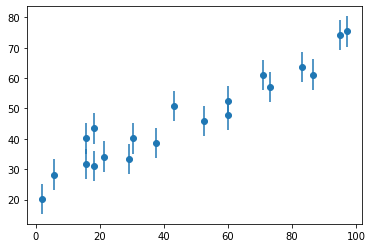

In [2]:
# Function that generates points following a linear trend. 
def make_data(intercept, slope, N=20,sigy=5, rseed=42):
    '''
    Parameters:
    -----------
    intercept, slope: parameters of the linear model
    sigy: width of normally distributed data points around the "true line"
    rseed: Seed of the random number generator (fixed for the sake of discussion)
    Output:
    -------
    x, y, sig_y 
    '''
    rand = np.random.RandomState(rseed)
    x = 100 * rand.rand(N)
    y = intercept + slope * x
    y += sigy * rand.randn(N)
    return x, y, sigy * np.ones_like(x)

theta_true = [25, 0.5]
x, y, sigy = make_data(theta_true[0], theta_true[1])  # could also be make_data(*theta_true)
plt.errorbar(x, y, sigy, fmt='o')

In [5]:
# Likelihood and Prior (cf Bayes_simple_modeling.ipynb)
def ln_likelihood(theta, x, y, sigy):
    y_model = theta[0] + theta[1] * x
    return -0.5 * np.sum(np.log(2 * np.pi * sigy ** 2) + (y - y_model) ** 2 / sigy ** 2)

def ln_flat_prior(theta):
    '''
    theta = shape(2) array containing the [intercept, slope] = [theta_0, theta_1]
    '''
    if np.all(np.abs(theta[1]) < 1000):
        return 0 # log(1)
    else:
        return -np.inf  # log(0)

In [6]:
def ln_posterior(theta, x, y, sigy):
    return ln_flat_prior(theta) + ln_likelihood(theta, x, y, sigy)

#### V.2.2.2 Using emcee to sample the posterior

EMCEE runs multiple chains in parallel, starting from different positions of the parameter space. The parameter `nwalker` of EMCEE sets the number of walkers. 

In [7]:
# !pip install emcee   # If emcee is not installed on your machine 

In [8]:
import emcee  # The commands below require emcee > v 3.0
import importlib
importlib.reload(emcee)

ndim = 2  # number of parameters in the model
nwalkers = 50  # number of MCMC walkers
#sampler.reset()  # Uncomment if you start over, ignoring what you did before

# initialize walkers: I.e. give the initial conditions for each of the chains !
# You can make a more refined start ! Closer to expected value parameters ... , e.g. based on MLE ...
starting_guesses = np.random.randn(nwalkers, ndim)

# Set up the sampler (we are sampling the unknown distribution)
sampler = emcee.EnsembleSampler(nwalkers, ndim, ln_posterior, args=[x, y, sigy])  # This sets up the posterior

# starting_guesses = The initial position vector.  
# Can also be None to resume from where :func:``run_mcmc`` left off the last time it executed.
# param1 = # of steps to run (here: 200)
#pos, prob, state = sampler.run_mcmc(starting_guesses, 200)  
samples_1 = sampler.run_mcmc(starting_guesses, 200)     # If 

In [9]:
chain_pos = samples_1.coords  # Final values of the parameters for each walker
chain_prob = samples_1.log_prob # Final values of the log_posterior for each walker
chain_pos.shape

(50, 2)

In [10]:
# We have run a first ensemble of chain of 200 steps for the 50 walkers and 2 parameters
# Those chains cab be retrieved with the function get_chain()
chains_1 = sampler.get_chain()  # Option Flat=True to get flattened chains ; discard(n) to discard "burn-in"; "thin" when autocorrelation has been calculated 
chains_1.shape

(200, 50, 2)

In [11]:
# We also have a record of the calculated log-posterior for the parameters that we can access with get_log_prob()
logP_chain_1 = sampler.get_log_prob()
logP_chain_1.shape

(200, 50)

In [12]:
# Note that the starting points of our chains are not included in chains_1 but you have them in the following array
starting_guesses.shape

(50, 2)

(18, 31)

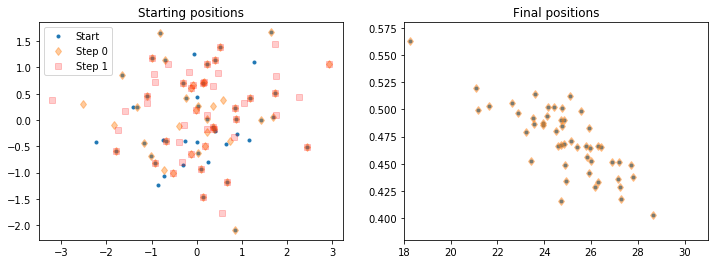

In [13]:
# Let's visualise the values of the parameters at start, step1 (left panel) ; and at the end of the chain (right)
f, ax = plt.subplots(ncols=2, figsize=(12,4))
ax[0].plot(starting_guesses[:,0], starting_guesses[:,1], ls='', marker='.', label='Start')
ax[0].set_title('Starting positions')
ax[0].plot(chains_1[0, :, 0], chains_1[0, :, 1], ls='', marker='d', alpha=0.4, label='Step 0')
ax[0].plot(chains_1[1, :, 0], chains_1[1, :, 1], ls='', color='red', marker='s', alpha=0.2, label='Step 1')
ax[0].legend()
ax[1].plot(chain_pos[:,0], chain_pos[:,1], ls='', marker='.')
ax[1].set_title('Final positions')
ax[1].plot(chains_1[199, :, 0], chains_1[199, :, 1], ls='', marker='d', alpha=0.4)
ax[1].set_ylim(0.38, 0.58)
ax[1].set_xlim(18, 31)

(-100, 0)

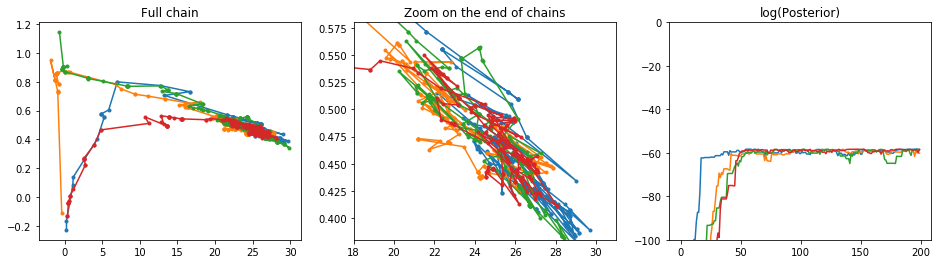

In [14]:
# Let's see the change of the parameters for four of the 50 walkers
# I select arbitrarily 4 walkers 
f, ax = plt.subplots(ncols=3, figsize=(16,4))
ax[0].set_title('Full chain')
for walker_id in [10, 20, 30, 40]: 
    ax[0].plot(chains_1[:, walker_id,  0], chains_1[:, walker_id, 1], marker='.')
    ax[1].plot(chains_1[:, walker_id,  0], chains_1[:, walker_id, 1], marker='.')
    ax[2].plot(logP_chain_1[:, walker_id])
ax[1].set_title('Zoom on the end of chains')
ax[1].set_ylim(0.38, 0.58)
ax[1].set_xlim(18, 31)
ax[2].set_title('log(Posterior)')
ax[2].set_ylim(-100, 0)

#### V.2.2.3 Plotting the chains

We can also look at the evolution of the 2 parameters (intercept -upper pannel- and slope -bottom pannel-) of the line along the chain. 

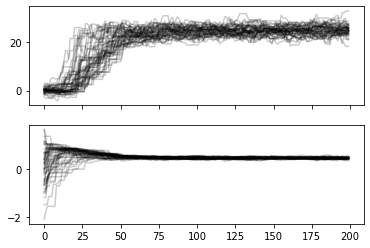

In [15]:
fig, ax = plt.subplots(2, sharex=True)
lab=['intercept', 'slope']
for i in range(2):
    ax[i].plot(chains_1[:, :, i], '-k', alpha=0.2)  
    ax[i].set_label(lab[i])

(-100, 0)

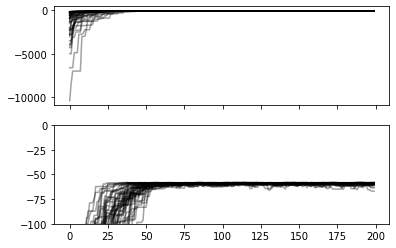

In [16]:
# We may want to look at the evolution of the posterior for each chain / walker 
fig, ax = plt.subplots(2, sharex=True)
for i in range(2):
    mf = ax[i].plot(logP_chain_1, '-k', alpha=0.2)
    mf = ax[i].plot(logP_chain_1, '-k', alpha=0.2)  # Zoom in version 
ax[1].set_ylim(-100,0)

#### V.2.2.4 Restarting after burn-in

The first part of the chain is not representative of the true posterior. We are too far from the maximum of the posterior and have a too large density of point in regions where the posterior is low (due to our arbitrary choice of initial conditions). This part of the chain is called *burn-in* and has to be ignored from the final sampling of the posterior. 

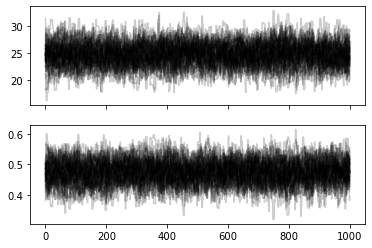

In [17]:
sampler.reset()  # We restart the MCMC using as initial guess the end-point of the previous chain (i.e. the burn-in). 
sample_2 = sampler.run_mcmc(initial_state = samples_1.coords, nsteps = 1000)  # We now take a longer chain

chain_2 = sampler.get_chain()
fig, ax = plt.subplots(2, sharex=True)
for i in range(2):
    ax[i].plot(chain_2[:, :, i], '-k', alpha=0.2)

Using the [corner.py](https://pypi.python.org/pypi/corner) package, we can take a look at this multi-dimensional posterior, along with the input values for the parameters:

In [16]:
# !pip install corner

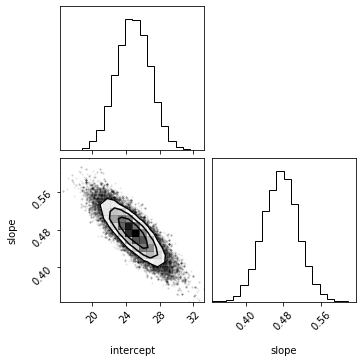

In [16]:
import corner
qq = corner.corner(sampler.flatchain, labels=['intercept', 'slope'])

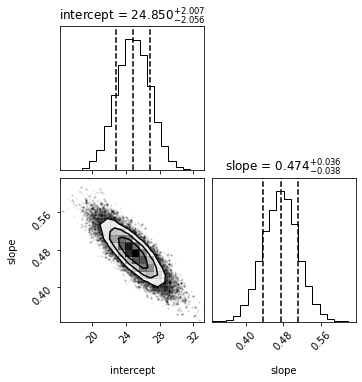

In [17]:
# Among the many options, one can also show the 68% marginalised credible intervals 
# As we have the PDF, the credible intervals can be derived directly from the quantiles
qq = corner.corner(sampler.flatchain, 
                   labels = ['intercept', 'slope'], 
                   quantiles = [0.16,0.5,0.84], 
                   title_quantiles = [0.16,0.5,0.84],
                   title_fmt = '.3f',
                   show_titles = True)

Beware that for a 2D distribution, the 1sigma level that is displayed only encompasses $\sim$ 39.3% of the volume. Indeed, in 2D, you can write the gaussian PDF (where I replaced $r^2 = x^2+y^2$ and assumed a center at (0,0)) as: 

$$
h(r;  0, \sigma) = \frac{1}{2 \pi \sigma^2} \exp{\left(-\frac{r^2}{2\sigma^2} \right)}
$$

Mind the normalisation factor which is now $1/(2 \pi \sigma^2)$ and not $1/\sqrt{2 \pi \sigma^2}$ as in 1D. 

The integral under this density (using polar coordinates; noticing that $\rm{d}x \, \rm{d}y = r \, \rm{d}r \, \rm{d}\theta$ ; and posing $u = r^2/2 \sigma^2$, so $du = r\,dr/\sigma^2$ ) is: 

$$
H(x) = \int_0^{2\pi} \int_0^x  \frac{1}{2 \pi \sigma^2} r \exp{\left(- \frac{r^2}{2\sigma^2}\right)} \rm{d}r \, \rm{d}\theta \\
= \int_0^x \frac{r}{\sigma^2} \exp{\left(- \frac{r^2}{2\sigma^2}\right)} \rm{d}r \\
= 1 - \exp{\left(\,\frac{x^2}{2\sigma^2}\right)} \\
$$

so, the volume within $1 \sigma$ is $1-\exp{(-0.5)} \sim 0.393$. 

Note that with `corner`, you can use the argument `levels` to set up different levels.

In [26]:
print(' 1 sigma = %.3f, \n 2 sigma = %.3f, \n 3 sigma = %.3f '%(1 - np.exp(-0.5), 1 - np.exp(-2.), 1 - np.exp(-9./2.)))

 1 sigma = 0.393, 
 2 sigma = 0.865, 
 3 sigma = 0.989 


In [18]:
# Note that you can also access the flattened chain by calling the get_chain() convenience function
chain_2_flat = sampler.get_chain(flat=True)

In [19]:
sampler.flatchain.shape, chain_2_flat.shape

((50000, 2), (50000, 2))

In [20]:
# We can derive the credible intervals from the chain
q0 = np.quantile(chain_2_flat[:, 0], q=[0.16,0.5,0.84])  # Returns an array w q_16, q_50, q_84
q1 = np.quantile(chain_2_flat[:, 1], q=[0.16,0.5,0.84])
print('Intercept: Median = %.3f ; 68pct CI: [%.3f, %.3f]'%(q0[1], q0[0], q0[2]))
print('Slope: Median = %.3f ; 68pct CI: [%.3f, %.3f]'%(q1[1], q1[0], q1[2]))

Intercept: Median = 24.809 ; 68pct CI: [22.756, 26.836]
Slope: Median = 0.475 ; 68pct CI: [0.438, 0.512]


In [21]:
# If corner is not installed, you can simply do the following
from scipy.stats import gaussian_kde
#t0, t1 = sampler.flatchain[:,0], sampler.flatchain[:,1]   # full chain ... a bit expensive for calculating the density of points
rd = np.random.choice(len(sampler.flatchain[:,0]), 1000)  # I pick 1000 random pos in my chain
t0 = [sampler.flatchain[i,0] for i in rd]
t1 = [sampler.flatchain[i,1] for i in rd]

In [22]:
# Calculate the point density
t01 = np.vstack([t0,t1]) # stack 1000 values of theta_0, theta_1 into a (2, 1000) array
kde_of_data = gaussian_kde(t01)  # kde representation of the data set 
density = kde_of_data(t01)   # kde representation evaluated at the pos of the data points 

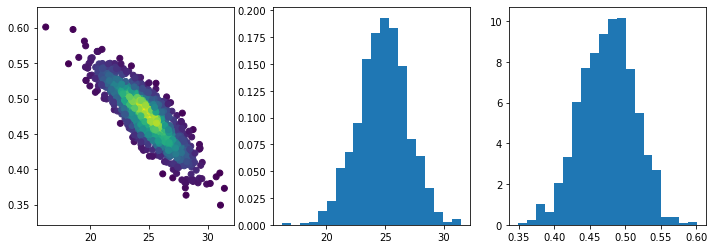

In [23]:
# Do the plot 
f, ax = plt.subplots(ncols=3, figsize=(12,4))
ax[0].scatter(t0, t1, c=density)
h1 = ax[1].hist(t0, bins=20, density=True)
h2 = ax[2].hist(t1, bins=20, density=True)

#### V.2.2.5 Visualizing the posterior

A way to visualize the posterior is to plot the model over the data.
Each point in the two-dimensional space ($\theta_0$,$\theta_1$) explored by the sampler, corresponds to a possible model for our data. If we select ~100 of these at random and plot them over our data, it will give us a good idea of the spread in the model results:

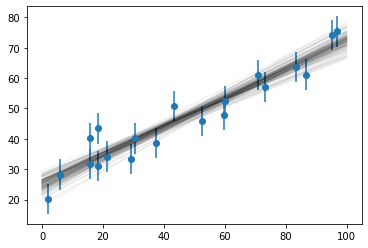

In [24]:
xfit = np.linspace(0, 100)
thetas = [chain_2_flat[i] for i in np.random.choice(chain_2_flat.shape[0], 100)]  # you randomly pick 100 pairs of parameters from the chain

for i in range(100):
    theta = thetas[i]
    plt.plot(xfit, theta[0] + theta[1] * xfit, color='black', alpha=0.05)

plt.errorbar(x, y, sigy, fmt='o');



In [26]:
#thetas

#### V.2.2.6: Chain convergence and auto-correlation time 

**This section is not mandatory for the lecture given in 2022-2023**

One of the difficult aspects of the MCMC is to estimate when to stop sampling and consider that the chain is converged. A common procedure is simply to plot the [evolution of the parameters](#V.2.2.4-Restarting-after-burn-in) as a function of the number of steps, as well as the evolution of the likelihood, as we did above. If the likelihood does not change with more steps, and parameters do not evolve substantially. Then you can work with the flattened chain to derive the posterior on the individual parameters.     
The above approach, while common, and generaly not yielding wrong inference, can however be dangerous as, e.g. your chain could remain in a local maximum of the ln(P) for a long time but not being converged. It can also be that you keep sampling the PDF while this is not necessary, wasting computer ressources. *Fortunately*, there is an objective way to evaluate if a chain is converged and decide when to stop sampling. This consists in calculating the [autocorrelation time](https://emcee.readthedocs.io/en/stable/tutorials/autocorr/#autocorr) of the chains. Recent versions of EMCEE (> 3.0) allow a calculation of the autocorrelation time while sampling as discussed here:  
https://emcee.readthedocs.io/en/stable/user/autocorr/ and https://emcee.readthedocs.io/en/stable/tutorials/autocorr/#autocorr. The underlying idea is to look at the evolution of the variance of the chain every $k$ steps ($k \sim 100$) and stop sampling when this variance gets stable (and is not dominated by sampling noise: when $k$ is small, your estimate of the auto-correlation time is too noisy to be reliable). The [EMCEE documentation](https://emcee.readthedocs.io/en/stable/tutorials/monitor/) gives you an example of implementation of the autocorrelation time calculation. As explained in the documentaion, the latter can then be used to select only "clean subsamples of the chains" (also called "thin") corresponding to well converged chains. This is done as follows: 
``` python 
tau = sampler.get_autocorr_time()
burnin = int(2 * np.max(tau))
thin = int(0.5 * np.min(tau))
samples = sampler.get_chain(discard=burnin, flat=True, thin=thin)
```
The bottleneck is that for some problems, the auto-correlation time gets so long that the chains may take too long to formally converge. The pragmatic approach underlined above may then be the only solution. As a good complement, one can study and fit the power spectrum of the chains as described in [Dunkley et al. 2004](https://arxiv.org/abs/astro-ph/0405462). A variety of other methods have been exist. For a really more in-depth discussion, one can consult the following paper by Cowles and Carlin (1996, Journal of the American Statistical Association, Vol. 91, N. 434, p883 -   https://www.jstor.org/stable/2291683) compares 13 of them.   

To further ensure that your final chain is well enough converged, you may consider running EMCEE multiple time **from different initial conditions**. If the retrieved PDF is stable over those many different sets of initial conditions, you may be confident that your chain is converged despite that autocorrelations time criterion not being fulfilled. 


#### V.2.2.7: Some other practical considerations

**IMPORTANT** 

- Always visualise your chains to see if they are converged. You may potentially also want to get rid of walkers that did not converge. Do not only check the posterior but also each individual parameter. 
- Visualising the chains also allows you to identify the burn-in phase and so get rid of those steps when calculating you posterior. Not removing the burned-in steps can yields a wrong PDF. 
- Recent versions of EMCEE allow you to carry out an efficient parallelization (i.e. over multiple CPUs) of the MCMC sampling, by running the different chains over different cores. This is described on this page: https://emcee.readthedocs.io/en/stable/tutorials/parallel/ 
- Starting with version 3, emcee has an interface for serializing the sampler output. This can be useful in any scenario where you want to share the results of sampling or when sampling with an expensive model because, even if the sampler crashes, the current state of the chain will always be saved. You will have to use the `backend` argument of the `sampler` object as described on this page: https://emcee.readthedocs.io/en/stable/user/backends/.
- The proposal probability used to accept/reject a new step in EMCEE and to move over the parameter space implemented in EMCEE is not the one described in the Metropolis Hasting algorithm. By changing the "move" function and "proposal density" one can reach a more efficient sampling. The so called "Stretch Move" implemented in emcee is e.g. not well suited to sample a multi-modal posterior. EMCEE now allows to test various "Moves" as explained here: https://emcee.readthedocs.io/en/stable/user/moves/#moves-user . 
- There are many other implementations of MCMC sampling. EMCEE is a simple to use and generally powerful one. However, if your problem is complex, or if you want to compare different models (you need to calculate and compare the Evidence), you may need to test alternative algorithms / implementations of posterior sampling. Here is a non exhaustive list of relevant algorithm you may want to consider: 
    * Nested sampling: Multinest: For multi-modal nested sampling: [Feroz,Hobson, and Bridges 2009]( https://ui.adsabs.harvard.edu/abs/2009MNRAS.398.1601F/abstract), MNRAS, 398, 1601.  
    * Ultranest: Buchner 2021 (https://arxiv.org/abs/2101.09675) provides a *nice review* of nested sampling and proposes a new formulation of nested sampling together with code available here: https://johannesbuchner.github.io/UltraNest/  
    * DINESTY: Dynamical nested sampling  [Speagle 2020](https://ui.adsabs.harvard.edu/abs/2020MNRAS.493.3132S/abstract), MNRAS, 493, 3132 and python code on github https://github.com/joshspeagle/dynesty.   
    * PolyChord: [W. J. Handley, Hobson, and Lasenby 2015a](https://ui.adsabs.harvard.edu/abs/2015MNRAS.450L..61H/abstract),[2015b](https://ui.adsabs.harvard.edu/abs/2015MNRAS.453.4384H/abstract) MNRAS, 450 L61 and MNRAS 453, 4384; [code](http://ascl.net/1502.011). See also [Higson 2018](https://ui.adsabs.harvard.edu/abs/2018JOSS....3..916H/abstract) for quality checks advises. 
    * DNEST4: Diffusive Nested sampling: [Brewer and Foreman-MacKey](https://ui.adsabs.harvard.edu/abs/2016arXiv160603757B/abstract) 2016 - arXiv:1603757.
    * Tool to visualise nested sampling results: Anesthetic - Handley 2019 https://joss.theoj.org/papers/10.21105/joss.01414 ; Superplot (for multinest): Fowlie et al. 2016 https://link.springer.com/article/10.1140/epjp/i2016-16391-0 

### V.2.3. Fitting a straight line with intrinsic scatter

Above we have done a simple model, where the data is drawn from a straight line.

Often, however, we will be modeling relationships where there is some intrinsic scatter in the model itself: that is, even if the data were *perfectly* measured, they would not fall along a perfect straight line, but would have some (unknown) scatter about that line.

Here we'll make a slightly more complicated model in which we will fit for the slope, intercept, and intrinsic scatter (i.e. intrinsic scatter is a parameter of our model) all at once.

<ErrorbarContainer object of 3 artists>

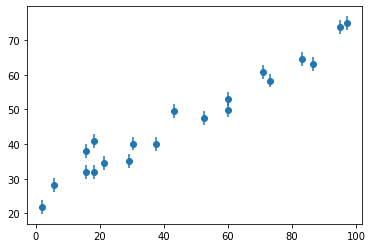

In [27]:
def make_data_scatter(intercept, slope, scatter, N=20, sigy=2, rseed=42):
    rand = np.random.RandomState(rseed)
    x = 100 * rand.rand(20)
    y = intercept + slope * x
    y += np.sqrt(sigy ** 2 + scatter ** 2) * rand.randn(20)
    return x, y, sigy * np.ones_like(x)

theta_truth = (25, 0.5, 3.0)  # (intercept, slope, intrinsic scatter)
x, y, sigy = make_data_scatter(*theta_truth)
plt.errorbar(x, y, sigy, fmt='o')

We will now go through the different steps to solve this problem in a Bayesian way, and use MCMC to evaluate the posterior on the parameters. 

#### V.2.3.1 Defining the likelihood and prior

You are now getting familiar with the first step of the procedure which consists in deriving an expression for the likelihood. The likelihood for this model looks very similar to what we used above, except that the intrinsic scatter is added *in quadrature* to the measurement error.


$$
P(D\mid\boldsymbol{\theta}) =  \prod_{i=1}^{N} \frac{1}{\sqrt{2\,\pi (\sigma_i^2 + \sigma^2)}} \, \exp\left[\left (\frac{ -(y_i - (\theta_0+\theta_1\,x_i))^2}{2\,(\sigma_i^2+\sigma^2)} \right)\right]
$$

For the prior, you can use either a flat or symmetric prior on the slope and intercept, but on the intrinsic scatter $\sigma$ it is best to use a scale-invariant Jeffreys Prior (see [References](#XX-References:) for more informations on this prior):

$$
P(\sigma)\propto\sigma^{-1}
$$

As discussed before, this has the nice feature that the resulting posterior will not depend on the units of measurement.

### Exercise

Now that you can go through the different steps needed to run a MCMC and derive the PDF of the 3 parameters of the model (i.e. intercept, slope, scatter). 

In [35]:
# Define functions to compute the log-prior, log-likelihood, and log-posterior
# theta = [intercept, slope, scatter]

def ln_prior(theta):
    if ((np.abs(theta[0]) < 1000) & ( theta[2] > 0)) :    # symmetric prior for theta1; 1/sigma for intrinsic scatter
        return -1.5 * np.log(1 + theta[1] ** 2) + np.log(1./theta[2])  
    else:
        return -np.inf  # log(0)
    
def ln_likelihood(theta, x, y, sigy):
    y_model = theta[0] + theta[1] * x
    S = sigy ** 2 + theta[2] ** 2
    return -0.5 * np.sum(np.log( 2 * np.pi * S ) 
                                + (y - y_model) ** 2 / S ) 

def ln_posterior(theta, x, y, sigy):
    return ln_prior(theta) + ln_likelihood(theta, x, y, sigy)                             


#### Sampling from the Posterior

In [36]:
# Using emcee, create and initialize a sampler and draw 200 samples from the posterior.
# Remember to think about what starting guesses should you use!
# You can use the above as a template

#import emcee
ndim = 3  # number of parameters in the model
nwalkers = 100  # number of MCMC walkers

# initialize walkers
starting_guesses = np.random.randn(nwalkers, ndim)

sampler = emcee.EnsembleSampler(nwalkers, ndim, ln_posterior, args=[x, y, sigy])

sample_1 = sampler.run_mcmc(starting_guesses, 1000)
chain_1 = sampler.get_chain()
chain1_pos = sample_1.coords  # last position of the chain  ; Not needed you can simply get it from chain_1[-1, :, :]


/Users/dsluse/miniconda3/envs/py3_lectures/lib/python3.7/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]


In [37]:
# for walker 0, comparison of last element of chain_1 and chain1_pos
chain_1[-1, 0, :], chain1_pos[0, :]

(array([24.49912444,  0.48695588,  2.19997356]),
 array([24.49912444,  0.48695588,  2.19997356]))

#### Visualizing the Chains

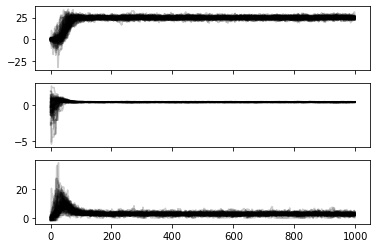

In [38]:
# Plot the three chains as for the example use of EMCEE
fig, ax = plt.subplots(3, sharex=True)
for i in range(3):
    ax[i].plot(chain_1[:, :, i], '-k', alpha=0.2)

#### Resetting and getting a clean sample

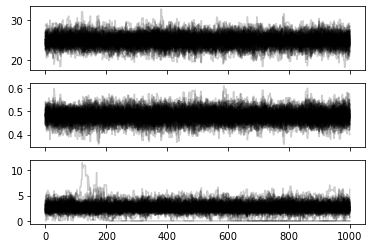

In [39]:
# Are your chains stabilized? Reset them and get a clean sample
sampler.reset()
sample_2 = sampler.run_mcmc(chain1_pos, nsteps = 1000)
chain_2 = sampler.get_chain()
chain_2_flat = sampler.get_chain(flat=True)
fig, ax = plt.subplots(3, sharex=True)
for i in range(3):
    ax[i].plot(chain_2[:, :, i], '-k', alpha=0.2)

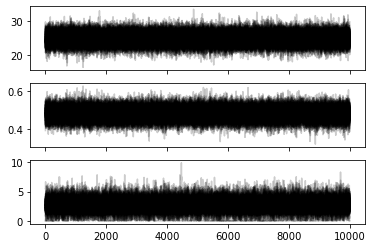

In [41]:
# The above chain is a bit odd with this small bump for low scatter.
# Let's run a longer chain to see if this is a real feature
sampler.reset()
chain2_pos = sample_2.coords
sample_3 = sampler.run_mcmc(chain2_pos, nsteps = 10000)
chain_3 = sampler.get_chain()
chain_3_flat = sampler.get_chain(flat=True)
fig, ax = plt.subplots(3, sharex=True)
for i in range(3):
    ax[i].plot(chain_3[:, :, i], '-k', alpha=0.2)

#### Visualizing the results

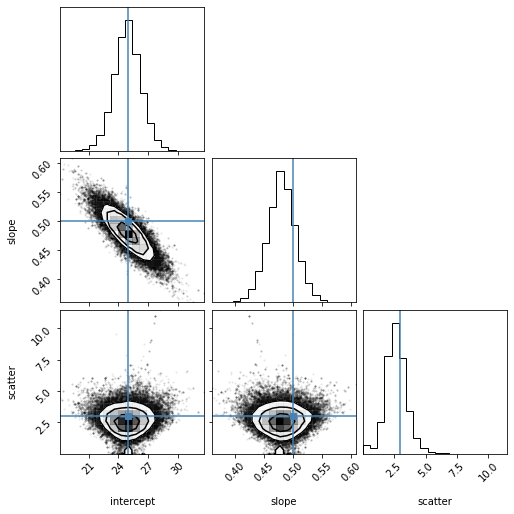

In [42]:
# Use e.g. corner.py to visualize the three-dimensional posterior
qq = corner.corner(chain_2_flat, truths=theta_truth, labels=['intercept', 'slope', 'scatter'])

In [43]:
for i in range(3):
    t_low, t_high = np.percentile(chain_3_flat[:,i], [(0.316/2.)*100., 100.-((0.316/2.)*100.)])
    print('(Marginalised) CI (68.4pct) for p%i = [%.2f, %.2f]'%(i, t_low, t_high))

(Marginalised) CI (68.4pct) for p0 = [23.56, 26.25]
(Marginalised) CI (68.4pct) for p1 = [0.46, 0.51]
(Marginalised) CI (68.4pct) for p2 = [1.90, 3.39]


In [44]:
# Check the shapes of the flat chains
chain_3_flat.shape

(1000000, 3)

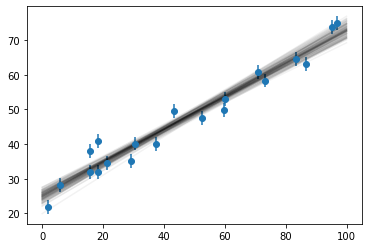

In [45]:
# Next plot ~100 of the samples as models over the data to get an idea of the fit
plt.errorbar(x, y, sigy, fmt='o');

thetas = [chain_3_flat[i] for i in np.random.choice(chain_2_flat.shape[0], 100)]  # Take 100 values from the final chain

xfit = np.linspace(0, 100)
for i in range(100):
    theta = thetas[i]
    plt.plot(xfit, theta[0] + theta[1] * xfit, color='black', alpha=0.05)

## XX References:

**Chapter 5** (5.1, 5.2, 5.3, 5.8) of the book <a class="anchor" id="book"></a> *Statistics, data mining and Machine learning in astronomy* by Z. Ivezic et al. in Princeton Series in Modern Astronomy. 

- This notebook includes a large fraction of the material that J. Vander Plas gave during the "Bayesian Methods in Astronomy workshop", presented at the 227th meeting of the American Astronomical Society. The full repository with that material can be found on GitHub: http://github.com/jakevdp/AAS227Workshop

- D. Hogg and D. Foreman-Mackey: Data analysis recipes: Using Markov Chain Monte Carlo https://arxiv.org/abs/1710.06068

- J.S. Speagle 2019: A Conceptual Introduction to Markov Chain Monte Carlo Methods https://arxiv.org/abs/1909.12313

- Jayes: [*Probability Theory: The Logic of Science*](http://bayes.wustl.edu/etj/prob/book.pdf).

- Foreman-Mackey et al. 2012 [*EMCEE, the MCMC hammer*](https://arxiv.org/abs/1202.3665) ; see also http://dan.iel.fm/emcee/current/

- About the variety of approaches to MCMC: Allison and Dunkley 2013: [Comparison of sampling techniques for Bayesian parameter estimation](https://arxiv.org/abs/1308.2675). See also [How to Be a Bayesian in Python](http://jakevdp.github.io/blog/2014/06/14/frequentism-and-bayesianism-4-bayesian-in-python/). 

- [MCMC for dummies](https://twiecki.io/blog/2015/11/10/mcmc-sampling/) or how to get some intuition about how and why MCMC works. 

- Andreon 2011 [Understanding better (some) astronomical data using Bayesian methods](https://arxiv.org/abs/1112.3652)

- **Video** explaining the MCMC and discussion on priors: 
    * An introduction to the Random Walk Metropolis algorithm by Ben Lambert https://www.youtube.com/watch?v=U561HGMWjcw 
    * About Jeffrey's prior: See Ben Lambdert's videos (3 videos; link to the first one): https://www.youtube.com/watch?v=S42N_6pQ5TA 